# <center>Glow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Invertible 1x1 Convolution:** 
LU Decomposition: $W=PL(U+\mathrm{diag}(s))$
where P is a fixed permutation matrix, L is a lower triangular matrix with 1 on the diagonal, U is a upper triangular matrix with 0 on the diagonal and s is a vector.
In practice, we first sample W as a rotation matrix and we compute the corresponding P, L, U and s.

**Act Norm:**
\begin{equation*}
    z' = s\odot z+b
\end{equation*}
$s$ and $b$ are initialized such that they have 0 mean and unit variance after an initial minibatch of data.

## Moons

In [4]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)


                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [26]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [27]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126800


0 1.8979618549346924
100 1.8093695640563965
200 1.6455154418945312
300 1.541808009147644
400 1.4139670133590698


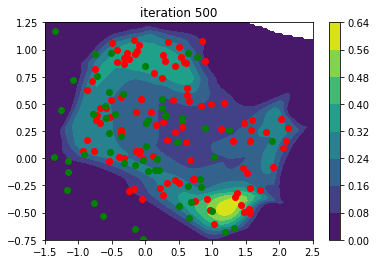

500 1.3517656326293945
600 1.338404893875122
700 1.4145787954330444
800 1.3233413696289062
900 1.3536477088928223


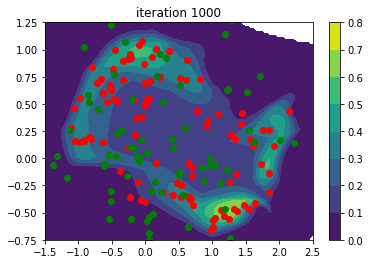

1000 1.3091630935668945
1100 1.413558840751648
1200 1.4460697174072266
1300 1.348231554031372
1400 1.4155447483062744


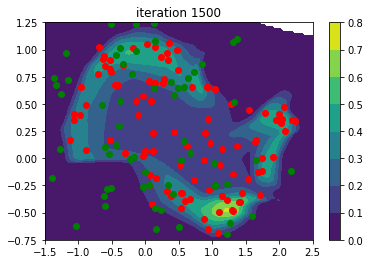

1500 1.3572998046875
1600 1.3338871002197266
1700 1.340743064880371
1800 1.3411548137664795
1900 1.2726463079452515


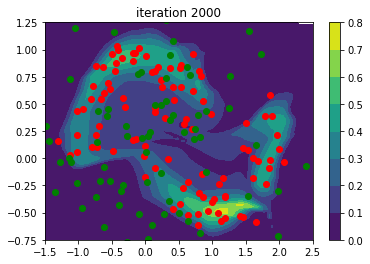

2000 1.2550299167633057
2100 1.286514163017273
2200 1.8579931259155273
2300 1.237436294555664
2400 1.356364130973816


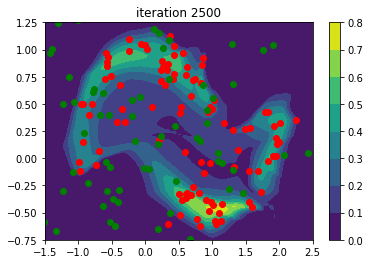

2500 1.4853547811508179
2600 1.3120402097702026
2700 1.395617127418518
2800 1.3929238319396973
2900 1.375646948814392


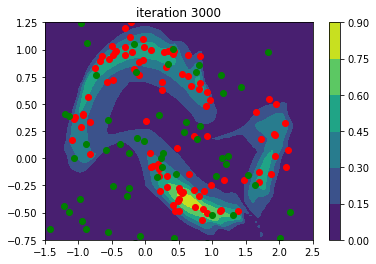

3000 1.378753423690796
3100 1.2868940830230713
3200 1.208998441696167
3300 1.2426278591156006
3400 1.2881121635437012


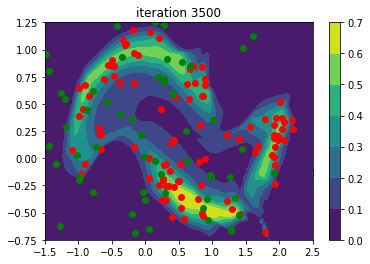

3500 1.214288353919983
3600 1.269076943397522
3700 1.2864155769348145
3800 1.233476996421814
3900 1.4177086353302002


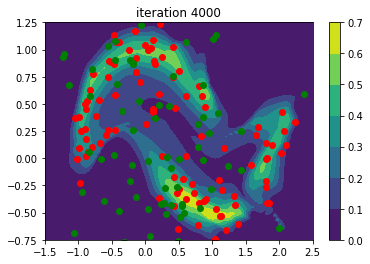

4000 1.2850642204284668
4100 1.210313320159912
4200 1.2618508338928223
4300 1.1691462993621826
4400 1.191212773323059


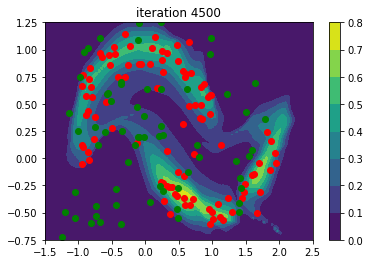

4500 1.1999684572219849
4600 1.2511274814605713
4700 1.1502132415771484
4800 1.1269525289535522
4900 1.094513177871704


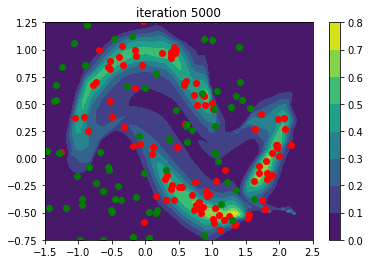

5000 1.1845886707305908
5100 1.2268905639648438
5200 1.1495356559753418
5300 1.1836988925933838
5400 1.1820480823516846


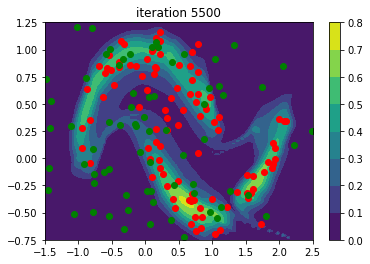

5500 1.1281816959381104
5600 1.1630005836486816
5700 1.1622231006622314
5800 1.1981732845306396
5900 1.105311632156372


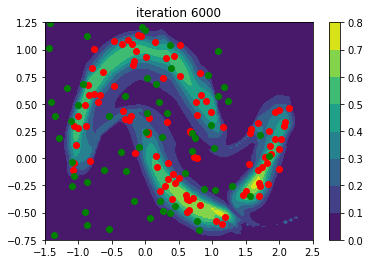

6000 1.130752444267273
6100 1.1899946928024292
6200 1.151238203048706
6300 1.1075036525726318
6400 1.0839998722076416


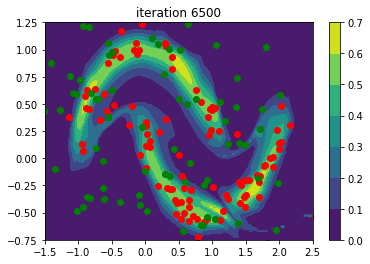

6500 1.0592894554138184
6600 1.2616047859191895
6700 1.1289873123168945
6800 1.1904196739196777
6900 1.1482244729995728


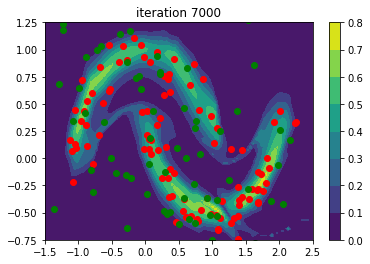

7000 1.2356432676315308
7100 1.177706241607666
7200 1.1699028015136719
7300 1.1196147203445435
7400 1.1104168891906738


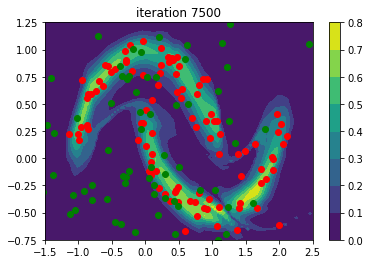

7500 1.1348077058792114
7600 1.1286669969558716
7700 1.1412931680679321
7800 1.108902931213379
7900 1.191035270690918


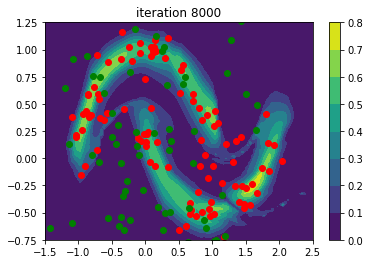

8000 1.1377712488174438
8100 1.1325465440750122
8200 1.1970876455307007
8300 1.142167091369629
8400 1.0599148273468018


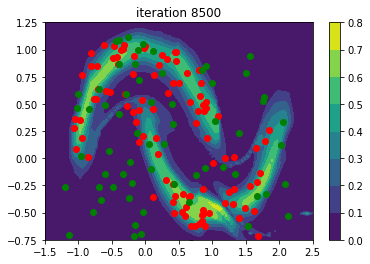

8500 1.1229054927825928
8600 1.1241002082824707
8700 1.085576057434082
8800 1.1102864742279053
8900 1.1987230777740479


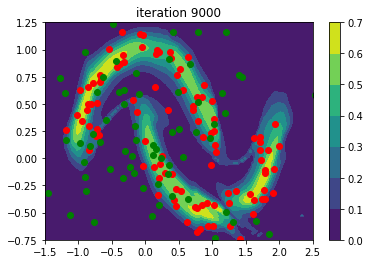

9000 0.9357227087020874
9100 1.2027108669281006
9200 1.125197172164917
9300 1.2152419090270996
9400 1.208766222000122


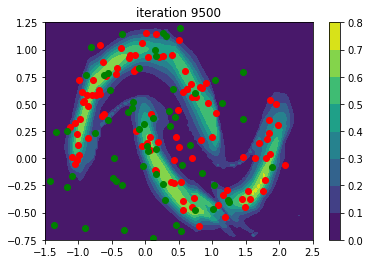

9500 1.0174810886383057
9600 1.0998250246047974
9700 1.2410938739776611
9800 1.1314222812652588
9900 1.1115331649780273


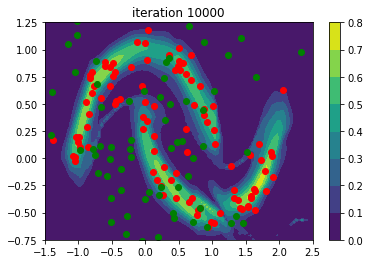

10000 1.1938650608062744


In [28]:
train_loss = train_moons(model)

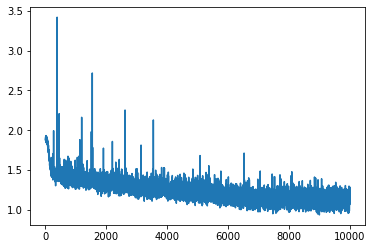

In [29]:
plt.plot(train_loss)
plt.show()

## MNIST

In [11]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [12]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


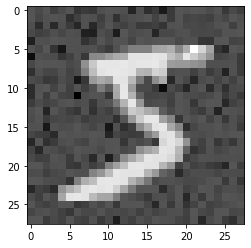

In [13]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [14]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [15]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [16]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [17]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    
model = NormalizingFlows(flows).to(device)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  24696640


0 1464.4886802559467


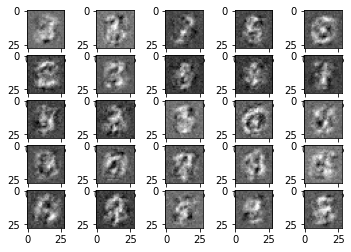

1 1425.4167662663247
2 1418.4347152872635
3 1412.3745374862574
4 1404.6343166457057
5 1397.006990542544
6 1390.3991975113272
7 1384.624687146022
8 1379.6019008612075
9 1375.1582989072494
10 1371.406534483692
11 1367.9821379118637
12 1364.8543099930037
13 1361.956737656583
14 1359.1985763842617
15 1357.0111289603879
16 1354.6395120519057
17 1352.6051996227013
18 1350.3384114409814
19 1348.8235646717585
20 1346.7652429121135
21 1345.4840400224048
22 1343.5624575747102
23 1342.0705339964518
24 1340.4664603357376
25 1339.2334921375266
26 1337.6651816947629
27 1336.5793558539613
28 1335.1737310413612
29 1333.8796902068896
30 1332.9476393839952
31 1331.1925543356044
32 1330.1983481205857
33 1329.0248768365204
34 1328.1307349621868
35 1326.9194075659648
36 1325.8543818296907
37 1324.6710163433668
38 1323.8701109408316
39 1322.4227248071861
40 1322.0084350846216
41 1320.614192743037
42 1320.0083182198662
43 1318.8516861319797
44 1317.5532864243237
45 1316.780308314732
46 1315.9770968504297
47 

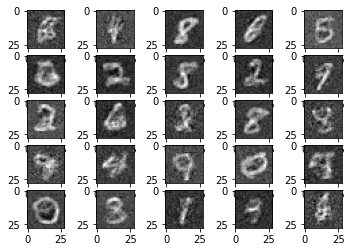

51 1310.6663982334421
52 1309.7678607867472
53 1309.1722474576059
54 1308.1065496839185
55 1307.1245182256962
56 1306.2276947086555
57 1305.0607441656116
58 1304.2504521026285
59 1303.13016391258
60 1302.3130135282017
61 1301.377962742787
62 1300.4589627719383
63 1299.5121414412313
64 1298.3663582547642
65 1297.758397084055
66 1296.6282925148255
67 1295.7674016566166
68 1294.6557304854077
69 1294.173055360058
70 1293.0555188274586
71 1292.6821963182135
72 1291.5946453558101
73 1290.943510336154
74 1289.9140947744536
75 1289.397652241721
76 1288.3402240159414
77 1287.7678196628465
78 1286.877955975563
79 1286.0404786717918
80 1285.4426381450726
81 1284.1562231913813
82 1283.576370467001
83 1282.7929049819263
84 1282.1970998280085
85 1281.4396764433968
86 1280.7958414366506
87 1280.0202886585487
88 1279.374720721865
89 1278.2862770064298
90 1278.0966505363806
91 1276.865936864922
92 1276.5071014209088
93 1275.4953462320095
94 1274.4335034335854
95 1273.9113350483908
96 1273.394807144523


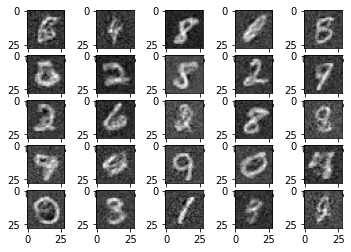

In [19]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [20]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [21]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

-2.3523765600272544


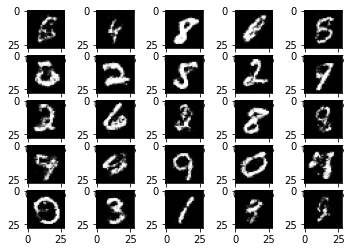

In [22]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>
Kingma, Durk P and Dhariwal, Prafulla
[1] Kingma, D. & Dhariwal, P. Glow: Generative flow with invertible 1x1 convolutions. arXiv preprint arXiv:1807.03039. (2018). [link](https://arxiv.org/pdf/1807.03039)